In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

Matplotlib is building the font cache; this may take a moment.


In [3]:
class ABCParameterNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ABCParameterNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.model(x)


In [5]:
def load_simulation_data(X_dir, param_path):
    with open(param_path, 'r') as f:
        param_dict = json.load(f)

    X_data, y_data = [], []

    for file in os.listdir(X_dir):
        if file.endswith('.csv') and file in param_dict:
            df = pd.read_csv(os.path.join(X_dir, file))
            df = df.drop(columns=["Time"], errors="ignore")
            X_data.append(df.values.flatten())
            y_data.append(list(param_dict[file].values()))

    return np.array(X_data), np.array(y_data), list(param_dict[list(param_dict.keys())[0]].keys())


In [19]:

X_dir = "../data/simulated/full_predator_prey/simulations"         # Folder with simulation .csv files
param_path = "../data/simulated/full_predator_prey/params/FullPredatorPreyModel_params.json"    # JSON file with simulation parameters
save_dir="../results/nn_results"
epochs=100
os.makedirs(save_dir, exist_ok=True)

In [11]:
X, y, param_names = load_simulation_data(X_dir, param_path)

In [12]:

# Normalize input and output
x_scaler = StandardScaler()
y_scaler = StandardScaler()
X = x_scaler.fit_transform(X)
y = y_scaler.fit_transform(y)

# Train/test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)

# Dataloaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)

In [13]:
# Model setup
model = ABCParameterNet(X.shape[1], y.shape[1])
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

train_losses = []
val_losses = []

In [15]:
# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        preds = model(batch_X)
        loss = criterion(preds, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    with torch.no_grad():
        val_preds = model(X_val)
        val_loss = criterion(val_preds, y_val).item()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


Epoch 0, Train Loss: 3.3404, Val Loss: 1.2617
Epoch 1, Train Loss: 3.4066, Val Loss: 1.2870
Epoch 2, Train Loss: 3.3609, Val Loss: 1.2828
Epoch 3, Train Loss: 3.4351, Val Loss: 1.2959
Epoch 4, Train Loss: 3.3712, Val Loss: 1.3140
Epoch 5, Train Loss: 3.6979, Val Loss: 1.2623
Epoch 6, Train Loss: 3.6721, Val Loss: 1.2413
Epoch 7, Train Loss: 3.6244, Val Loss: 1.2615
Epoch 8, Train Loss: 3.9290, Val Loss: 1.3587
Epoch 9, Train Loss: 6.9555, Val Loss: 1.2268
Epoch 10, Train Loss: 3.6298, Val Loss: 1.1983
Epoch 11, Train Loss: 3.4257, Val Loss: 1.1600
Epoch 12, Train Loss: 3.4212, Val Loss: 1.9002
Epoch 13, Train Loss: 4.1327, Val Loss: 1.5803
Epoch 14, Train Loss: 3.8227, Val Loss: 1.1405
Epoch 15, Train Loss: 3.3270, Val Loss: 1.1463
Epoch 16, Train Loss: 3.2337, Val Loss: 1.1648
Epoch 17, Train Loss: 3.1264, Val Loss: 1.1790
Epoch 18, Train Loss: 3.1547, Val Loss: 1.1676
Epoch 19, Train Loss: 3.2070, Val Loss: 1.1785
Epoch 20, Train Loss: 3.0999, Val Loss: 1.1932
Epoch 21, Train Loss: 3

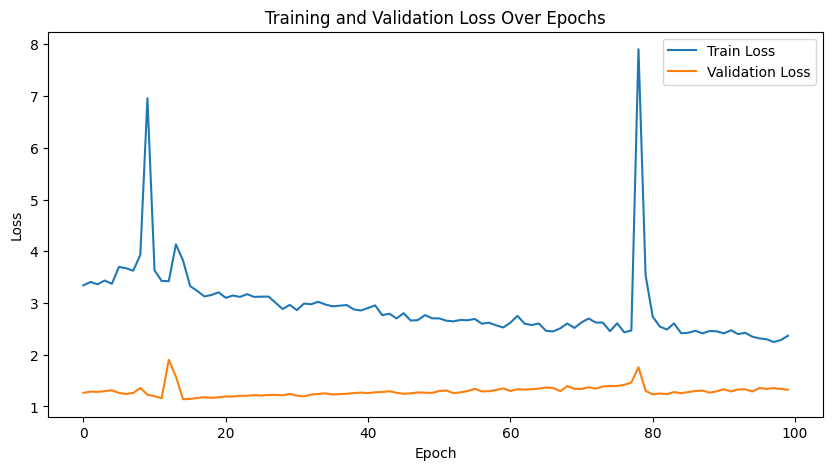

In [20]:

# Plot training vs validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.savefig(os.path.join(save_dir, 'loss_curve.png'))
plt.show()


In [17]:
# Final predictions vs true values
model.eval()
with torch.no_grad():
    final_preds = model(X_val).numpy()
    true_vals = y_val.numpy()
    # Inverse transform to original scale
    final_preds = y_scaler.inverse_transform(final_preds)
    true_vals = y_scaler.inverse_transform(true_vals)


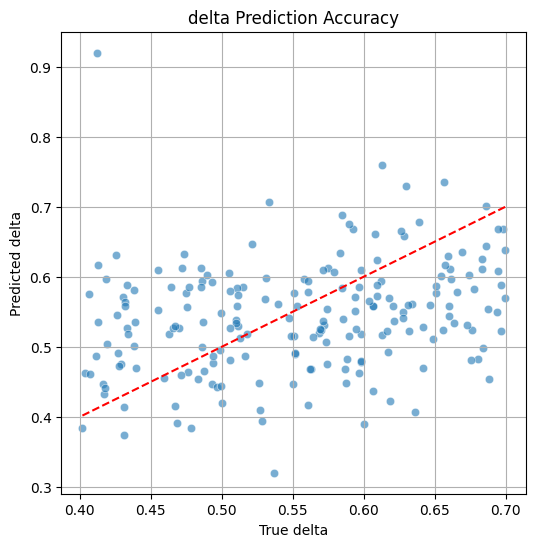

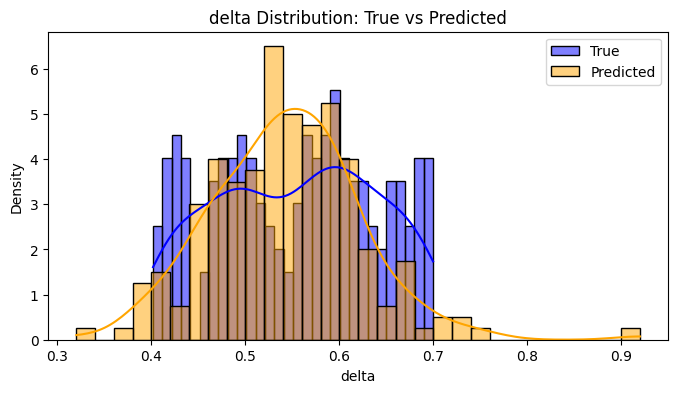

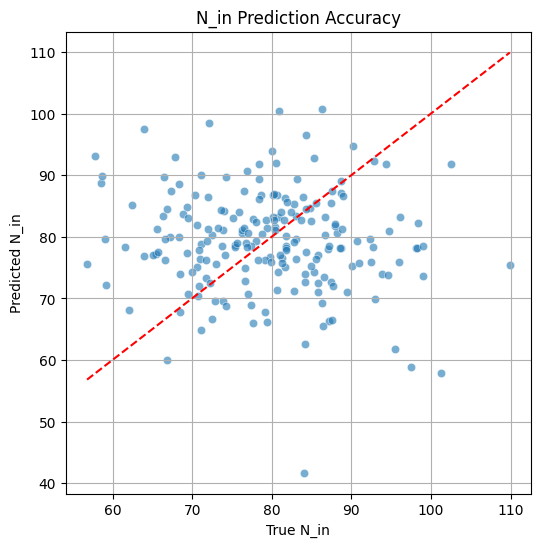

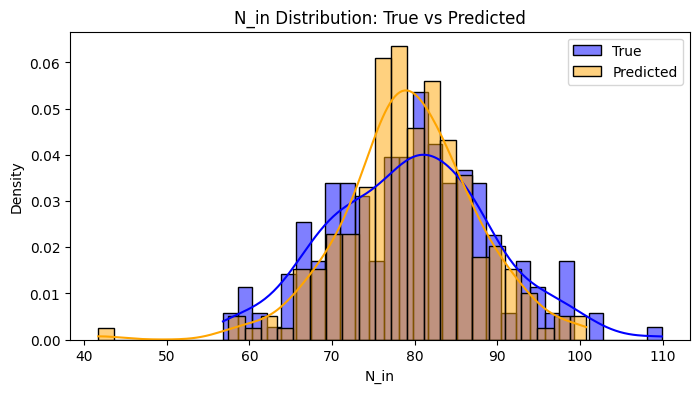

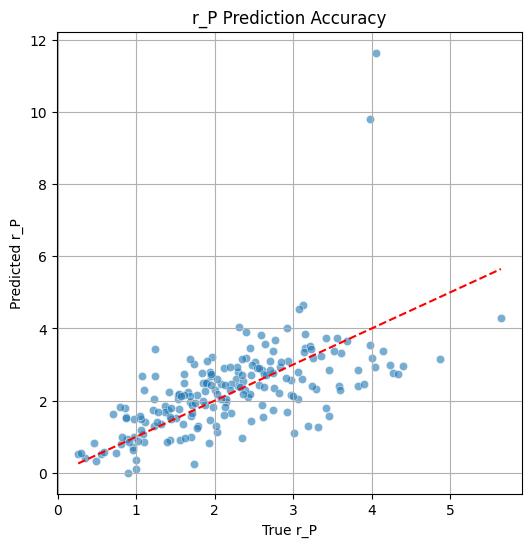

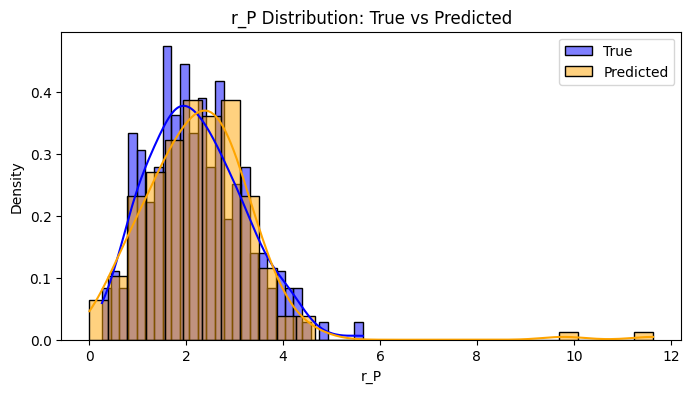

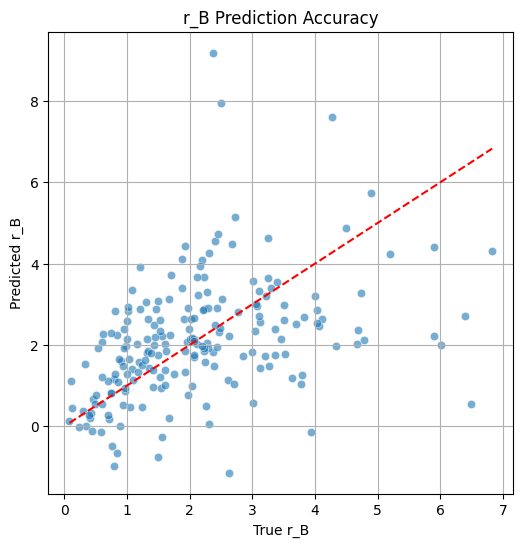

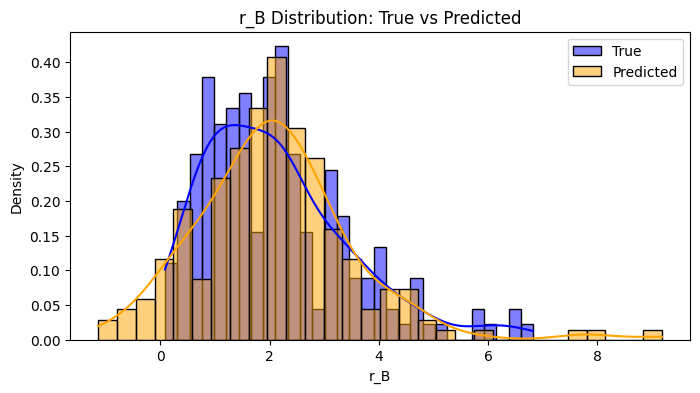

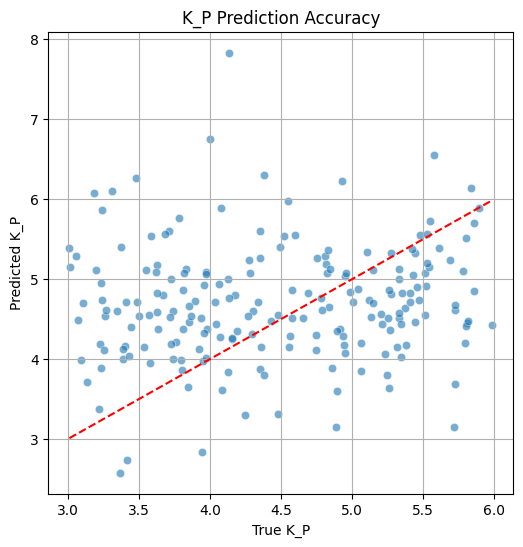

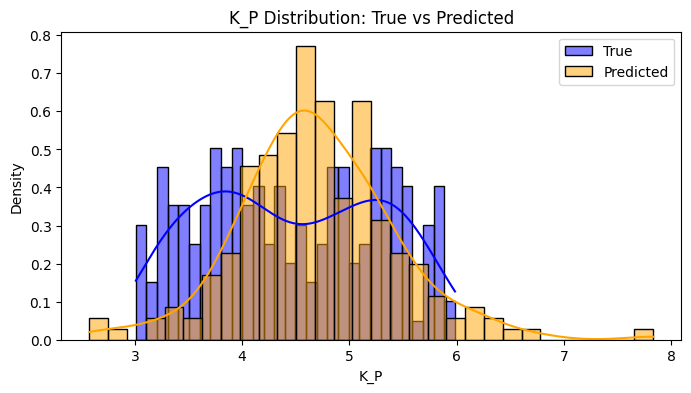

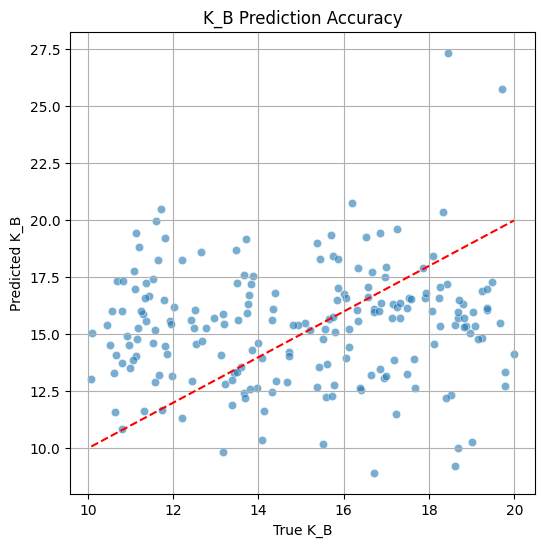

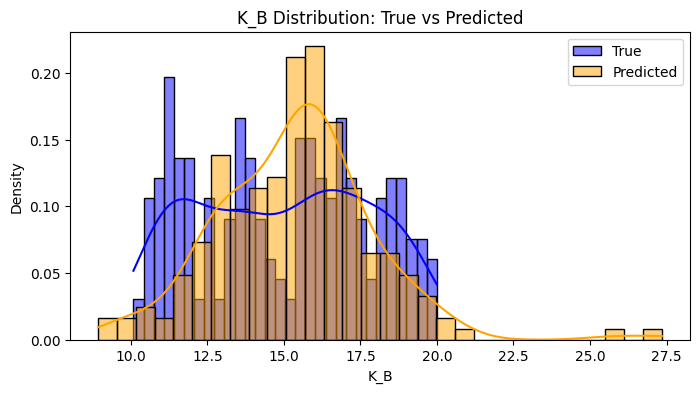

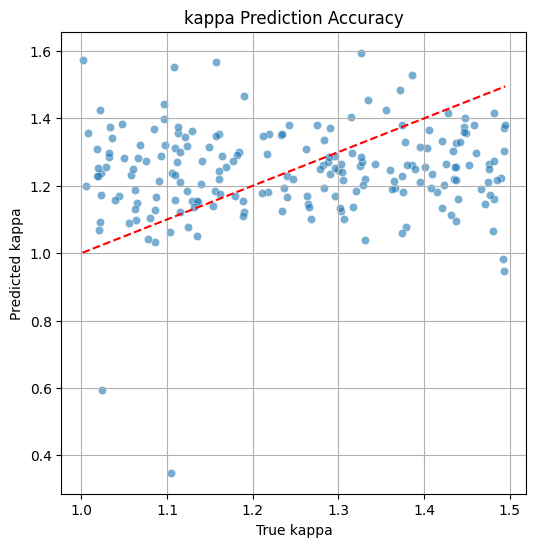

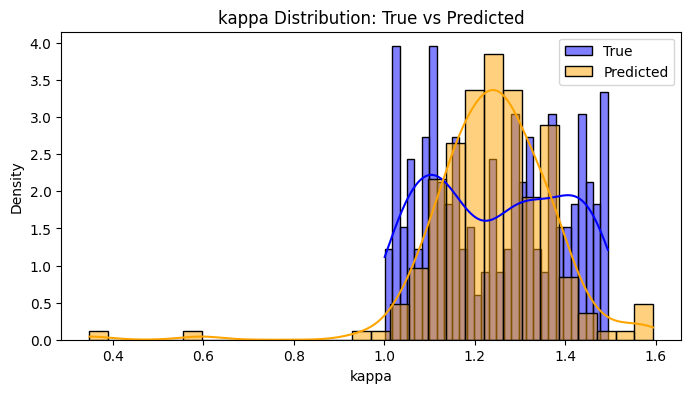

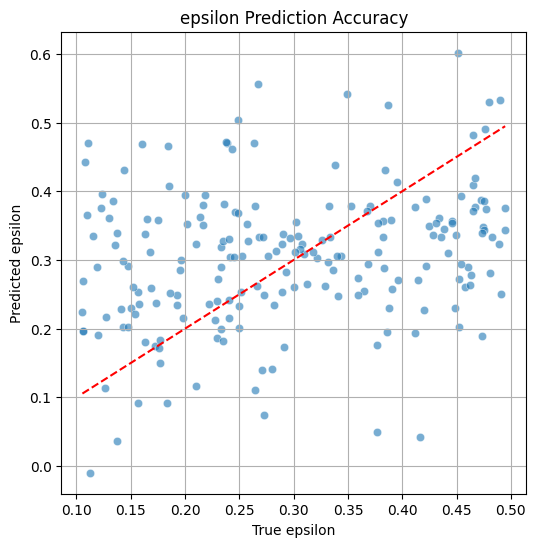

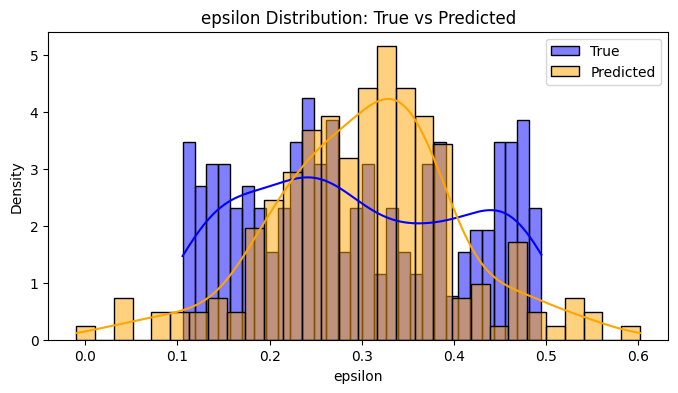

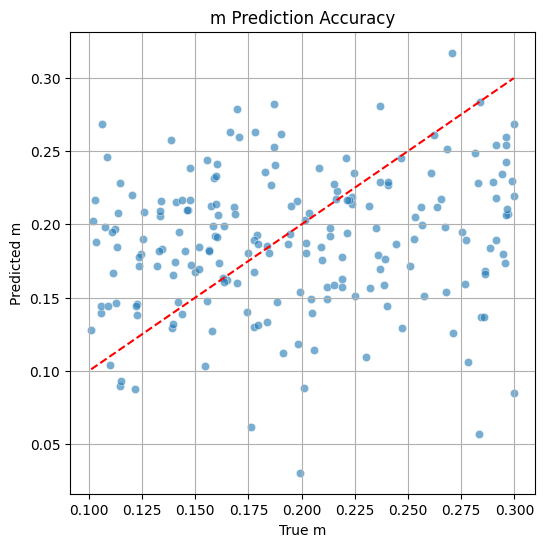

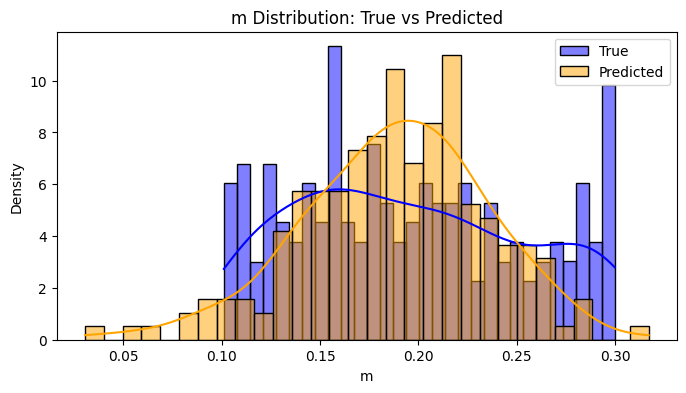

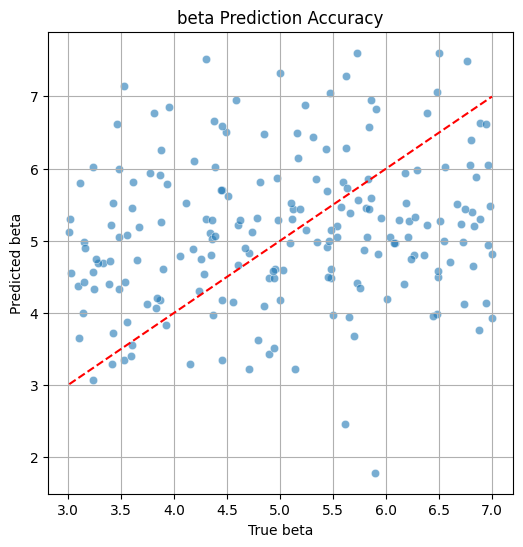

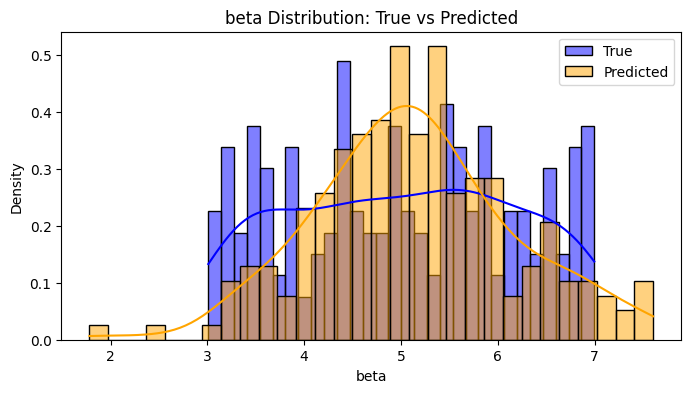

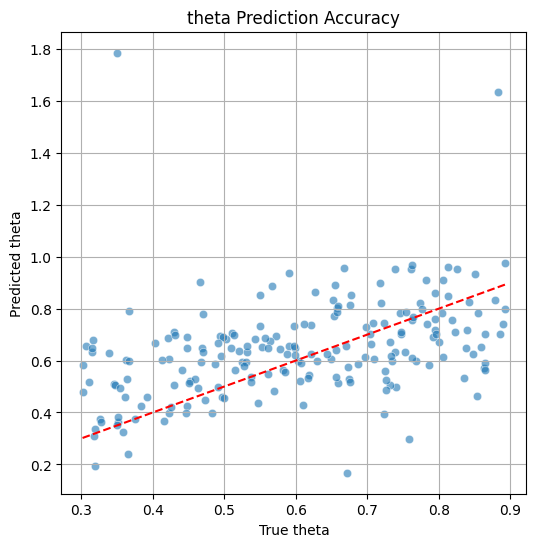

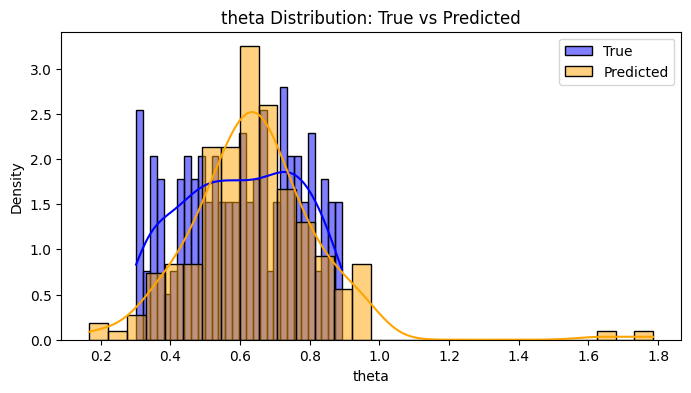

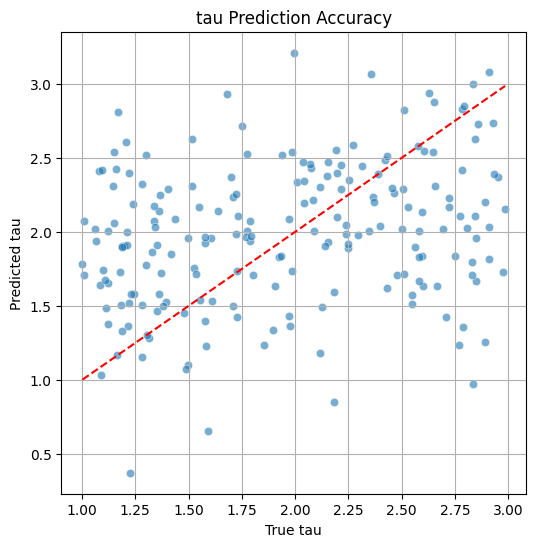

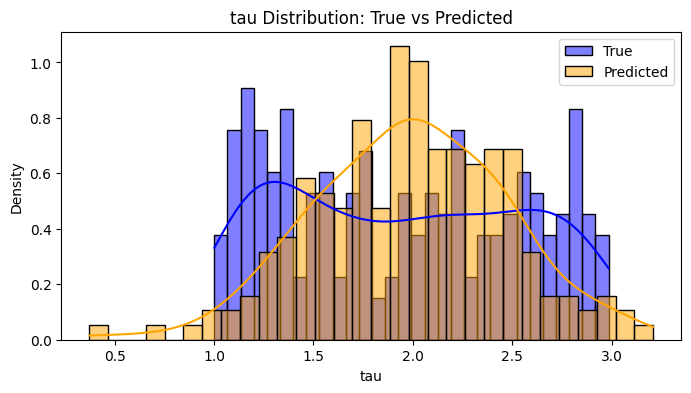

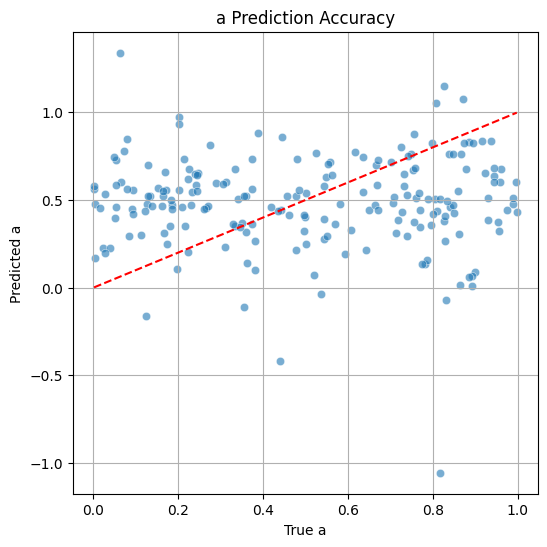

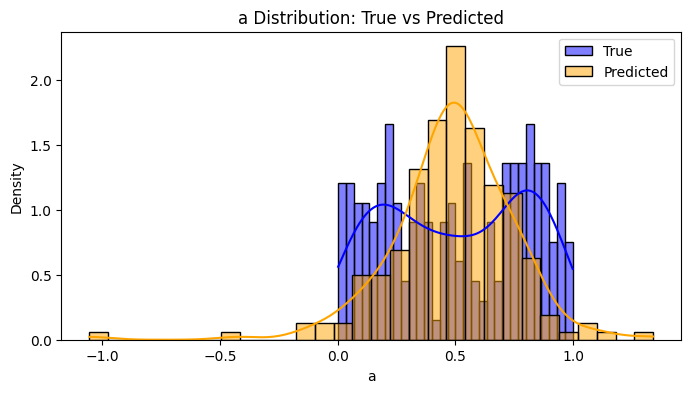

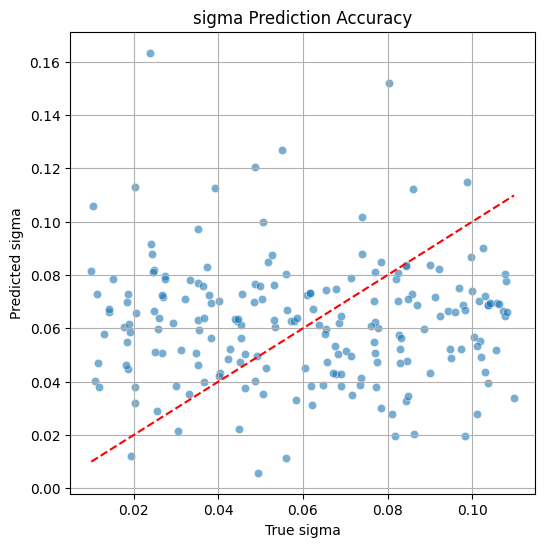

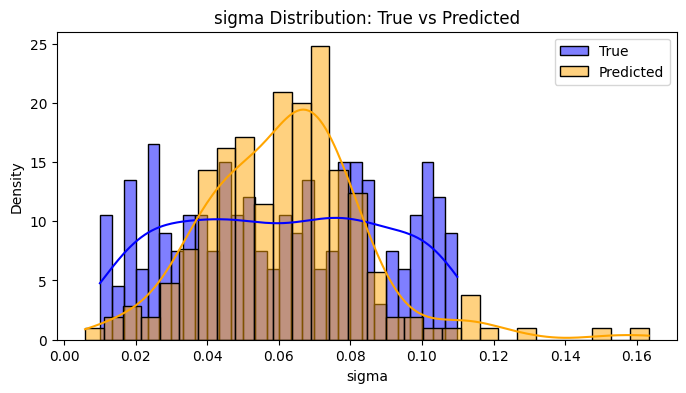

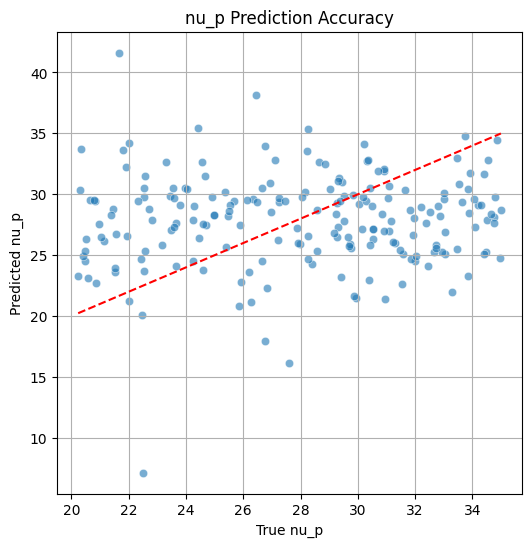

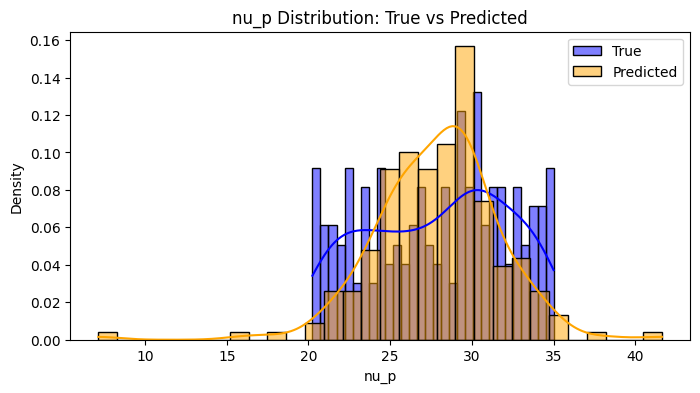

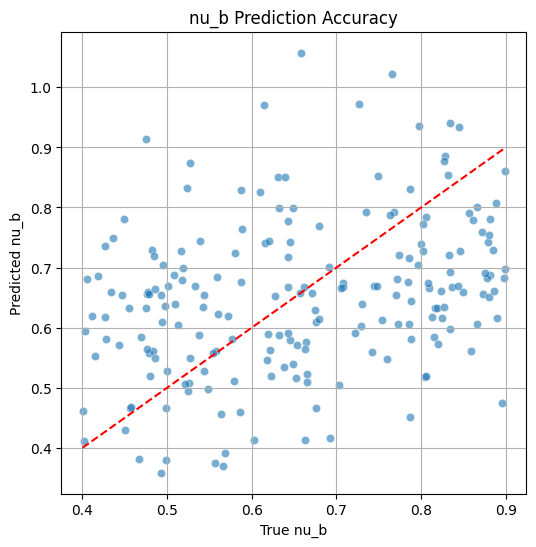

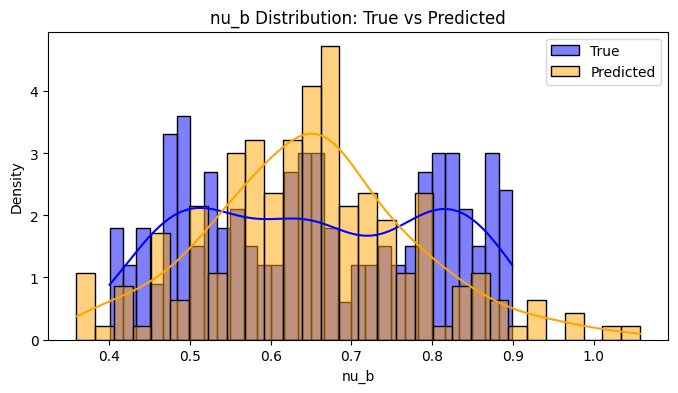

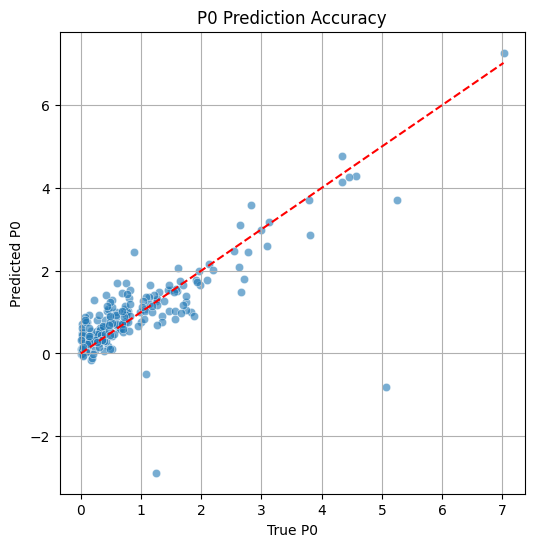

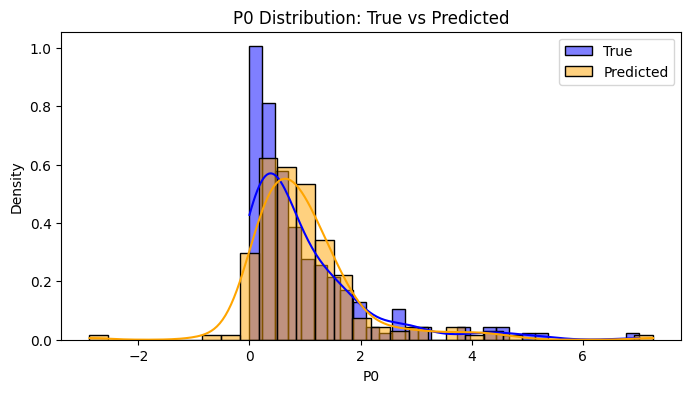

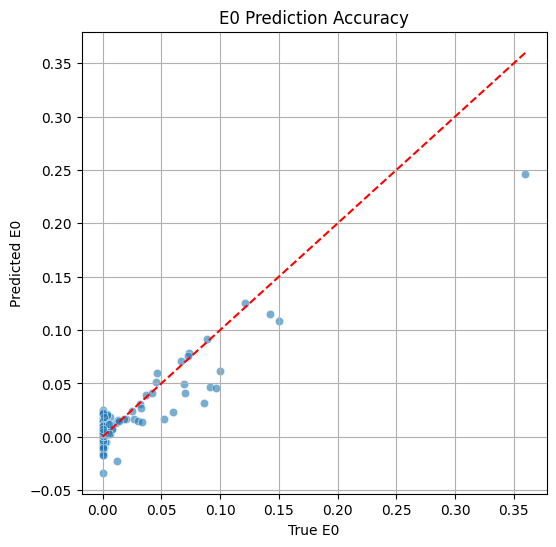

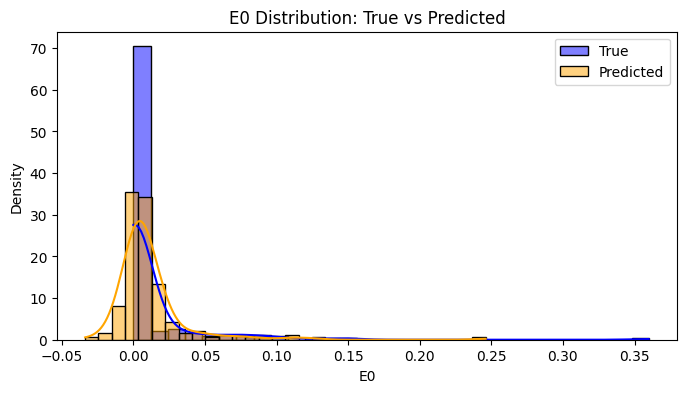

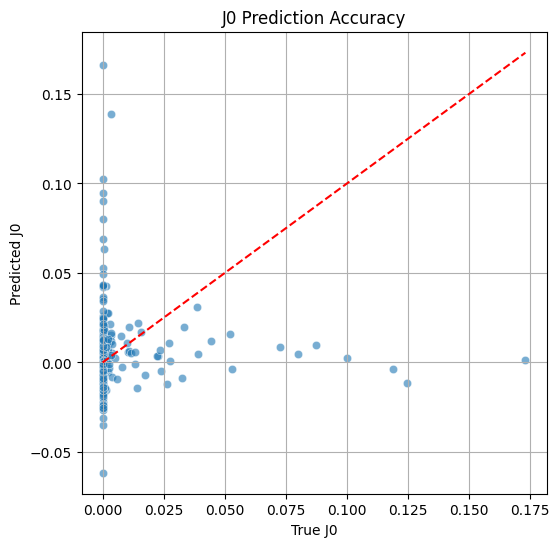

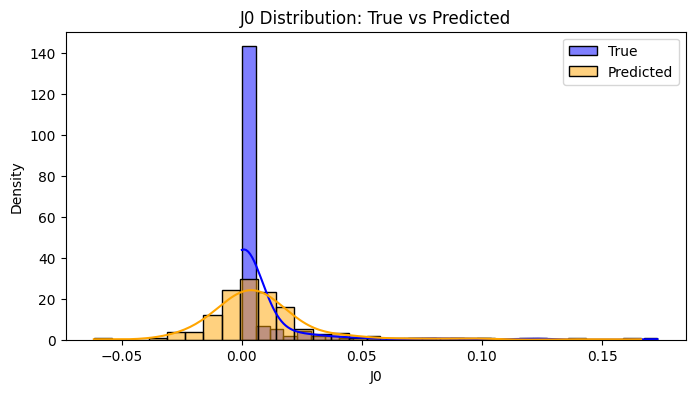

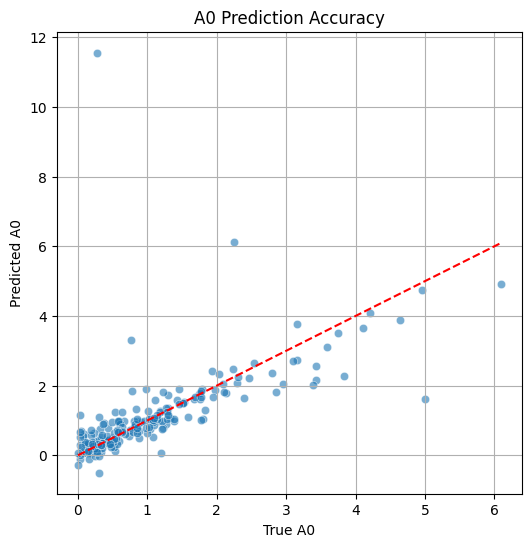

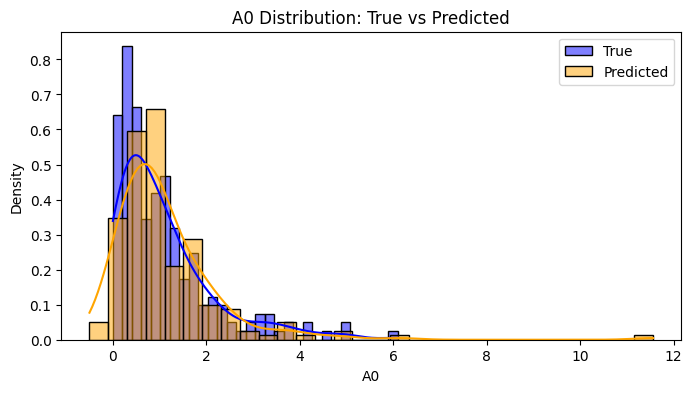

In [21]:
# Plot predicted vs true for each parameter and save histograms
for i, name in enumerate(param_names):
    # Scatter plot
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=true_vals[:, i], y=final_preds[:, i], alpha=0.6)
    plt.plot([true_vals[:, i].min(), true_vals[:, i].max()],
                [true_vals[:, i].min(), true_vals[:, i].max()], '--r')
    plt.xlabel(f'True {name}')
    plt.ylabel(f'Predicted {name}')
    plt.title(f'{name} Prediction Accuracy')
    plt.grid(True)
    plt.savefig(os.path.join(save_dir, f'scatter_{name}.png'))
    plt.show()

    # Histogram comparison
    plt.figure(figsize=(8, 4))
    sns.histplot(true_vals[:, i], label='True', color='blue', kde=True, stat="density", bins=30)
    sns.histplot(final_preds[:, i], label='Predicted', color='orange', kde=True, stat="density", bins=30)
    plt.title(f'{name} Distribution: True vs Predicted')
    plt.xlabel(name)
    plt.ylabel('Density')
    plt.legend()
    plt.savefig(os.path.join(save_dir, f'distribution_{name}.png'))
    plt.show()
